In [2]:
erc20_abi = [
    {
        "constant": True,
        "inputs": [{"name": "_owner", "type": "address"}],
        "name": "balanceOf",
        "outputs": [{"name": "balance", "type": "uint256"}],
        "type": "function",
    },
    {
        "constant": True,
        "inputs": [],
        "name": "decimals",
        "outputs": [{"name": "", "type": "uint8"}],
        "type": "function",
    },
    {
        "constant": True,
        "inputs": [],
        "name": "symbol",
        "outputs": [{"name": "", "type": "string"}],
        "type": "function",
    },
]


In [3]:
from web3 import Web3
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from hexbytes import HexBytes
import os
import requests
import dotenv

dotenv.load_dotenv()
ETHERSCAN_API_KEY = os.getenv("ETHERSCAN_API_KEY")

def get_transactions_for_address(address, start_block=0, end_block=99999999):
    url = f"https://api.etherscan.io/api?module=account&action=txlist&address={address}" \
          f"&startblock={start_block}&endblock={end_block}&sort=asc&apikey={ETHERSCAN_API_KEY}"
    response = requests.get(url)
    data = response.json()
    if data['status'] != "1":
        print(f"No transactions found or error: {data.get('message')}")
        return []
    return data['result']

# Get transactions where initial_address is the sender

web3 = Web3(Web3.HTTPProvider("https://muddy-bitter-dew.quiknode.pro/8d853a8106f75d700a1904f46105e55fc2a637ae"))



TRANSFER_EVENT_SIG = HexBytes("ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef")

def parse_erc20_transfers(tx_hash):
    # Get the transaction receipt, which includes all logs.
    receipt = web3.eth.get_transaction_receipt(tx_hash)
    print("Receipt has", len(receipt.logs), "log(s).")  # Debug: count of logs.
    
    erc20_transfers = []
    for log in receipt.logs:
        topics_hex = [topic.hex() for topic in log.topics]
        print("Log topics:", topics_hex)
        
        # Check if the first topic matches the standard ERC20 Transfer signature.
        if log.topics and log.topics[0].hex() == TRANSFER_EVENT_SIG.hex():
            # Make sure there are at least 3 topics (Transfer events have 3 topics: signature, from, to)
            if len(log.topics) < 3:
                print("Warning: Log with Transfer signature has less than 3 topics. Skipping.")
                continue

            token_contract_address = log.address

            # Extract addresses from topics (last 40 hex digits represent the address).
            from_address = "0x" + log.topics[1].hex()[-40:]
            to_address   = "0x" + log.topics[2].hex()[-40:]


            try:
                amount_wei = int(log.data.hex(), 16)
            except Exception as e:
                print("Error converting log data to int:", e)
                continue

            transfer_info = {
                "token_address": token_contract_address,
                "from": from_address,
                "to": to_address,
                "amount_wei": amount_wei,
            }
            return transfer_info

def path_from_hash(tx_hash):
    tx = web3.eth.get_transaction(tx_hash)
    block_number = tx['blockNumber']

    # Check if it's a native ETH transfer (empty input)
    if tx["input"] == HexBytes('0x') or tx["input"] == b'':
        dest = tx['to']
        tx_list = get_transactions_for_address(dest, block_number)
        tx_eth = [
            tx for tx in tx_list 
            if tx['input'] == '0x' and int(tx['value']) > 0
        ]
        return tx_eth
    else:
        transfer = parse_erc20_transfers(tx_hash)
        print(transfer["token_address"])
        print(transfer["from"])
        print(transfer["to"])
        print(transfer["amount_wei"])
        print("Subgraph exists")
        #Check ig subgraph exists
        #Get all tx from subgraph
    
path_from_hash("0xc330fa1c577b7f088351df585aa4e28f5acc28e53d42ba08ab94fb09387dd7ec")

Receipt has 1 log(s).
Log topics: ['ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef', '000000000000000000000000cb52c356f2710039bb2898aef910782c43cd7f47', '000000000000000000000000cfbf9cbae28b537f3dcb079ccc2728a1b221bb1d']
0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48
0xcb52c356f2710039bb2898aef910782c43cd7f47
0xcfbf9cbae28b537f3dcb079ccc2728a1b221bb1d
137000000
Subgraph exists


Graph constructed with:
 - 4 nodes
 - 3 edges


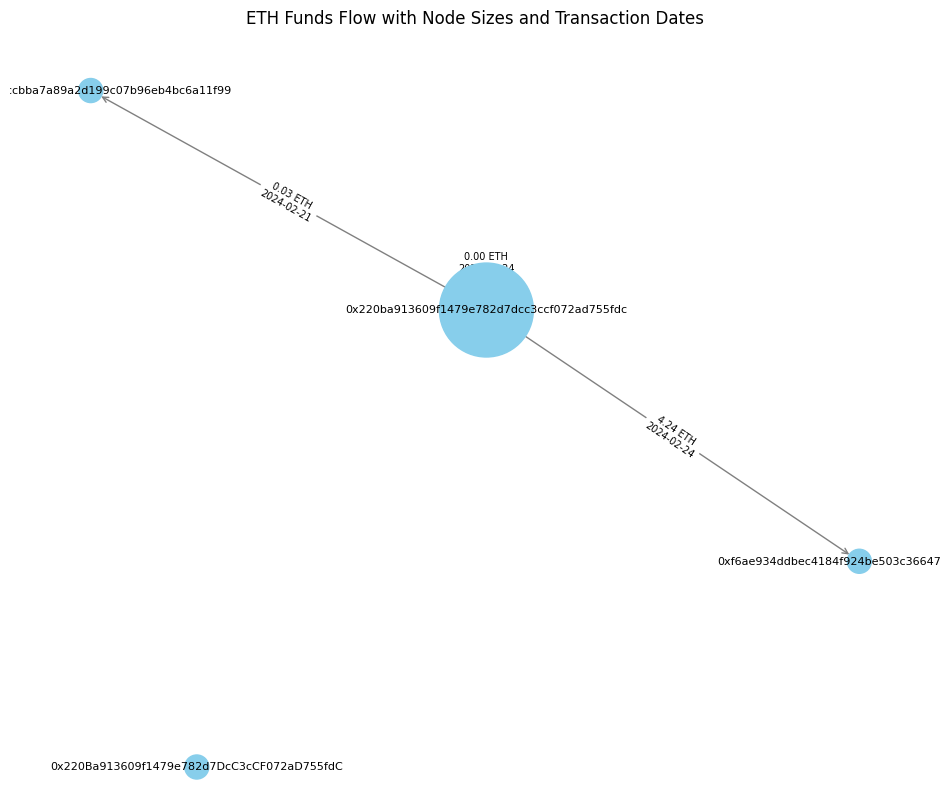

In [4]:
import networkx as nx
tx_list = path_from_hash("0x2fea75a3b5616727f6569fb013802b88b8bca90e902043ade7c48e1081b1925e")

# Create a directed graph
G = nx.DiGraph()
initial_address = "0x220Ba913609f1479e782d7DcC3cCF072aD755fdC"
# Add the initial address as a node
G.add_node(initial_address)

# Process each transaction to add nodes and edges
for tx in tx_list:
    # Make sure this is an outbound transaction
    if tx['from'].lower() != initial_address.lower():
        continue
    
    sender = tx['from']
    receiver = tx['to']
    # Convert value from Wei to ETH (1 ETH = 10^18 Wei)
    value_eth = int(tx['value']) / (10 ** 18)
    block_number = tx['blockNumber']
    timestamp = int(tx['timeStamp'])
    
    # Add nodes if not already added
    G.add_node(sender)
    G.add_node(receiver)
    
    # Add an edge from sender to receiver with transaction attributes
    G.add_edge(sender, receiver, value=value_eth, block=block_number, timestamp=timestamp)
    
print("Graph constructed with:")
print(f" - {G.number_of_nodes()} nodes")
print(f" - {G.number_of_edges()} edges")

node_total_value = {}
for node in G.nodes():
    total = sum(data['value'] for _, _, data in G.out_edges(node, data=True))
    node_total_value[node] = total

# Set node sizes (base size + scale factor * total ETH)
node_sizes = [300 + 1000 * node_total_value.get(node, 0) for node in G.nodes()]

# --- Prepare edge labels that include the ETH value and transaction date ---
edge_labels = {}
for u, v, data in G.edges(data=True):
    if data['value'] >= 0.001:
        date_str = pd.to_datetime(data['timestamp'], unit='s').strftime('%Y-%m-%d') if 'timestamp' in data else ''
        label = f"{data['value']:.2f} ETH\n{date_str}"
        edge_labels[(u, v)] = label

# --- Layout and Drawing ---
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, iterations=20)

# Draw nodes with the calculated sizes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color='gray')

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=8)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("ETH Funds Flow with Node Sizes and Transaction Dates")
plt.axis('off')
plt.show()